# Taller 2
### Brayan José Calderón Amorocho
## Problem 1
Train an SVM for detecting whether a word belongs to English or Spanish.
## Problem 1(a)
Build training and test data sets. You can use the most frequent words in http://
en.wiktionary.org/wiki/Wiktionary:Frequency_lists. Consider words at least 4
characters long and ignore accents.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import chi2_kernel



In [2]:
def clean_db(db,lang):
    db["len"] = db["palabra"].str.len()
    db.drop('frecuencia', inplace=True, axis=1)
    db = db[db["len"] >= 4]
    db["palabra"] = db['palabra'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')        
    if lang == "es":
        db["lang"] = "es"
    else:
        db["lang"] = "en"
    return db

In [172]:
es_db = pd.read_csv("https://raw.githubusercontent.com/BrayanCalderon/Machine/main/Taller2/es_50k.txt",sep = " ")
es_db.shape

(50000, 2)

In [4]:
es_db[:5]

,palabra,frecuencia
0,de,14459520
1,que,14421005
2,no,12379505
3,a,9549646
4,la,9125471


In [171]:
en_db = pd.read_csv("https://raw.githubusercontent.com/BrayanCalderon/Machine/main/Taller2/en_50k.txt",sep = " ")
en_db.shape

(50000, 2)

In [6]:
es_df = clean_db(es_db,"es")
en_df = clean_db(en_db,"en")

/tmp/ipykernel_7029/4277495815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["palabra"] = db['palabra'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
/tmp/ipykernel_7029/4277495815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db["lang"] = "es"
/tmp/ipykernel_7029/4277495815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [7]:
print(es_df.head(3))
print(en_df.head(3))

   palabra  len lang
19    para  4.0   es
20    esta  4.0   es
22    pero  4.0   es
   palabra  len lang
7     that  4.0   en
11    what  4.0   en
14    this  4.0   en


In [8]:
words_df = pd.concat([es_df[:4000], en_df[:4000]], ignore_index=True)
print(words_df.head(5),words_df.shape)

  palabra  len lang
0    para  4.0   es
1    esta  4.0   es
2    pero  4.0   es
3    bien  4.0   es
4    como  4.0   es (8000, 3)


In [9]:
X = words_df["palabra"]
#Realizo Onehot Encoding para el lenguage
y = words_df["lang"]
Y = list(y)
Y = np.array([1 if y == "en" else 0 for y in Y])

In [10]:
# Split the data with training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((5360,), (2640,), (5360,), (2640,))

## Problem 1(b)
Implement different string kernels:
- Histogram cosine kernel: calculate a bag of n-grams representation (use the CountVectorizer from scikit-learn) and apply the cosine_similarity from scikit-learn.
- Histogram intersection: calculate a bag of n-grams representation, normalize it (the
sum of the bins must be equal to 1 ∀i, ||xi
||1 = 1.) and calculate the sum of the
minimum for each bin of the histogram.
- χ2 kernel: calculate a bag of n-grams representation and apply the chi2_kernel
from scikit-learn.
- SSK kernel: use the code available at this repository https://github.com/helq/
python-ssk.


## Histogram Cosine Kernel

In [11]:
#Instanciamos CountVectorizer
vectorizer = CountVectorizer(ngram_range = (1,1), analyzer = 'char')

#Alimentamos al objeto vectorizer con los datos de train
X1 = vectorizer.fit_transform(x_train)

print(X1.shape)
X1.toarray()

(5360, 27)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [24]:
#Calculamos y guardamos los n-grams (2,2)(2,3)(2,4) en una lista que está conformada
# los datos de train y los datos de test
n_grams_train =  []
n_grams_test  =  []
for n in range(1,5):
    vectorizer = CountVectorizer(ngram_range = (1,n), analyzer = "char")
    n_grams_train.append(vectorizer.fit_transform(x_train))
    n_grams_test.append(vectorizer.transform(x_test))

In [13]:
#Kernel utilizando cosine similarity utilizando el primer n-grams
K_cosine = cosine_similarity(X1)
K_cosine.shape

(5360, 5360)

In [14]:
K_cosine[:3,:3]

array([[1.        , 0.31622777, 0.53033009],
       [0.31622777, 1.        , 0.2236068 ],
       [0.53033009, 0.2236068 , 1.        ]])

In [25]:
#Aplicamos el kernel para la los n-grams obtenidos anteriormente
Kcosine_n = [cosine_similarity(gram) for gram in n_grams_train]
Kcosine_n[1][:3]

array([[1.        , 0.19518001, 0.31448545, ..., 0.14285714, 0.        ,
        0.        ],
       [0.19518001, 1.        , 0.14322297, ..., 0.19518001, 0.07784989,
        0.09759001],
       [0.31448545, 0.14322297, 1.        , ..., 0.20965697, 0.2508726 ,
        0.        ]])

## Histogram Intersection

In [16]:
#https://github.com/gmum/pykernels/blob/master/pykernels/regular.py
def compute_hist_kernel(h1,h2):
    h1 = normalize(h1)
    h2 = normalize(h2)
    kernel = np.zeros((h1.shape[0],h2.shape[0]))
    for d in range(h1.shape[1]):
            column_1 = h1[:, d].reshape(-1, 1)
            column_2 = h2[:, d].reshape(-1, 1)
            kernel += np.minimum(column_1, column_2.T)
    return kernel
def normalize(h):
    return h/np.sum(h, axis = 1)
    

In [123]:
#Normalizamos valores utilizando el bag of words calculado anteriormente
N1 = X1/np.sum(X1, axis = 1)
K_hist = compute_hist_kernel(N1,N1) 

In [31]:
Khist_n = [compute_hist_kernel(gram, gram) for gram in n_grams_train]

## 3. χ2 kernel

In [17]:
K = chi2_kernel(n_grams_train[0].todense(), n_grams_train[0].todense())

/home/brayancalderon/anaconda3/envs/machine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/brayancalderon/anaconda3/envs/machine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [18]:
K.shape

(5360, 5360)

In [28]:
Kchi_n = [chi2_kernel(gram.todense(),gram.todense()) for gram in n_grams_train]

/home/brayancalderon/anaconda3/envs/machine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/brayancalderon/anaconda3/envs/machine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/brayancalderon/anaconda3/envs/machine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

## SSK Kernel
Use the code available at this repository https://github.com/helq/python-ssk


In [1]:
!pip install cython

## Problem 1(c)

Use scikit-learn to train different SVMs using precomputed kernels. Use cross validation to find appropriate regularization parameters plotting the training and validation error vs. the regularization parameter. Use a logarithmic scale for $C$, $\{2^{-15} ,2^{-14},...,2^{10}\}$. Try different configurations of the parameters (in particular different $n$ values for the $n$-grams).

In [22]:

#Codigo basado en: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html

def get_scores(kernel, Y, C):
    '''
    kernel: Precomputed kernel,
    Y: target train
    C: set of regularization parameters
    '''
    _clf = svm.SVC(kernel='precomputed')
    _grid = GridSearchCV(_clf, cv=2, param_grid={'C': C}, return_train_score=True)
    _grid.fit(kernel, Y)
    _scores = _grid.cv_results_['mean_test_score']
    max_train = np.argmax(_grid.cv_results_['mean_train_score'])
    max_test = np.argmax(_grid.cv_results_['mean_test_score'])
    return {
        'train': {
        'scores': _grid.cv_results_['mean_train_score'],
        'error': 1 - _grid.cv_results_['mean_train_score'],
        'C': C[max_train],
        'score':  _grid.cv_results_['mean_train_score'][max_train]
      },
    'validation': {
        'scores': _grid.cv_results_['mean_test_score'],
        'error': 1 - _grid.cv_results_['mean_test_score'],
        'C': C[max_test],
        'score':  _grid.cv_results_['mean_test_score'][max_test]
      }
  }

def plot_rp(d, kernel_name, n_gram, cs):
    '''
    d: Results from get_scores
    kernel_name: Title to plot
    n_gram: n_gram
    '''
    fig, axes = plt.subplots( figsize=(10, 6))
    axes.set_xlabel('Regularization Parameter')
    axes.set_ylabel('Error')
    axes.set_title(f'Kernel: {kernel_name}, {n_gram}-gram')
    x_box = min(min(d['train']['error']), min(d['validation']['error']))
    axes.text(2 ** (-14), x_box, f"Best Regularization parameter:\nTrain C : {d['train']['C']}, Error: {round(1 -  d['train']['score'],4)}\nTest  C : {d['validation']['C']}, Error: {round(1 -  d['validation']['score'],4)}",
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
    colors = ['navy', 'red', 'darkorange']
    axes.semilogx(cs, d['train']['error'], color='red', label=f'Train')
    axes.semilogx(cs, d['validation']['error'], color='navy', label=f'Validation')  
    plt.legend()
    plt.show()


def reg_parameters(title, kernels, Y):
    '''
    title: Title for plot
    kernels: Set of precomputed kernels
    Y: Target
    '''
    cs = [2**(i) for i in range(-15, 11)]
    for idx, K in enumerate(kernels):
        scores = get_scores(K, Y, cs)
        plot_rp(scores, title, idx + 1, cs)

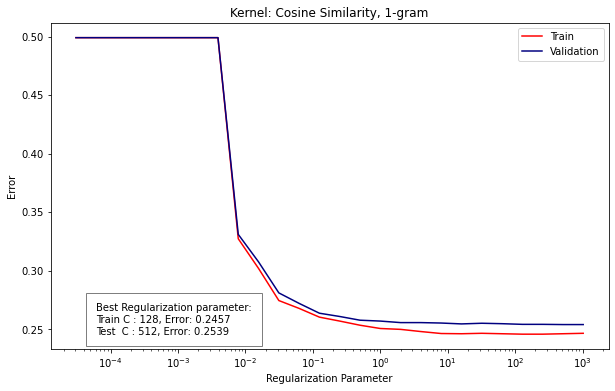

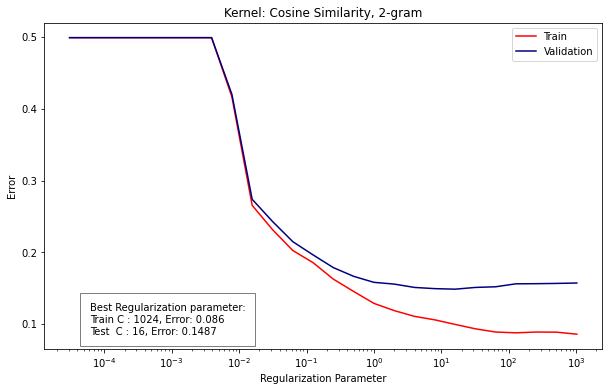

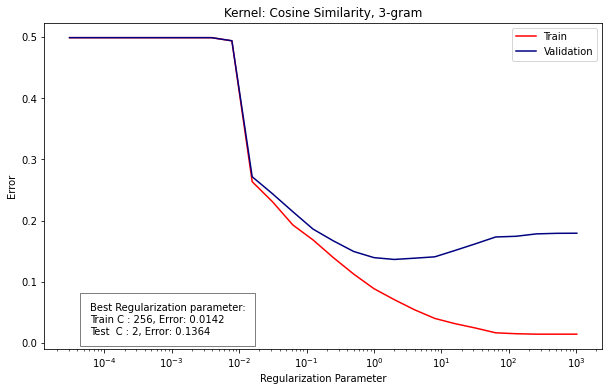

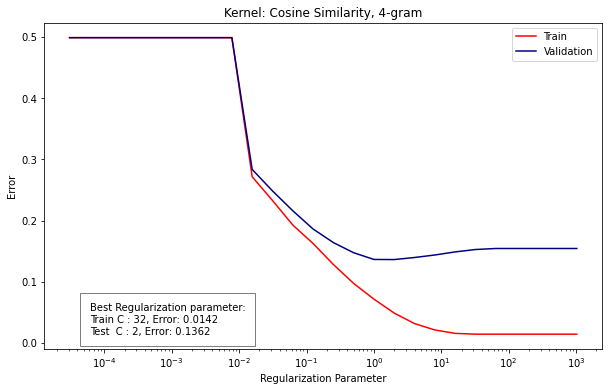

In [26]:
reg_parameters('Cosine Similarity', Kcosine_n, y_train)

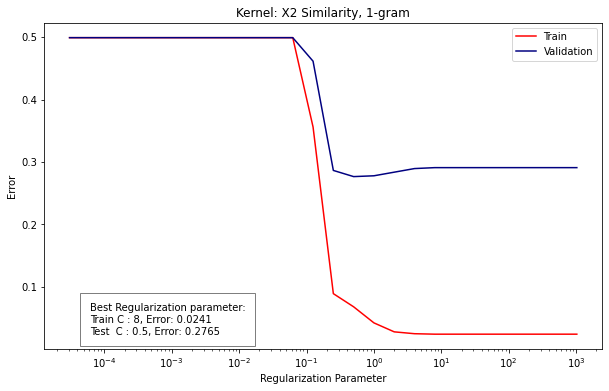

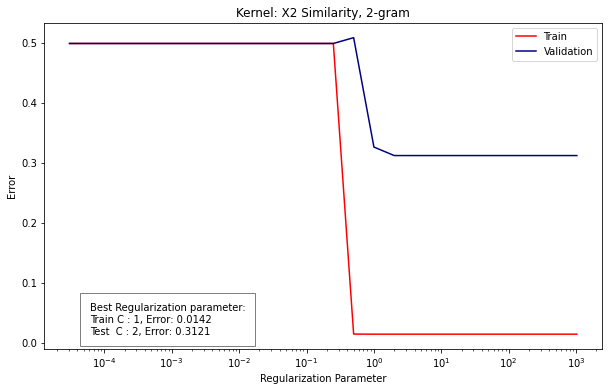

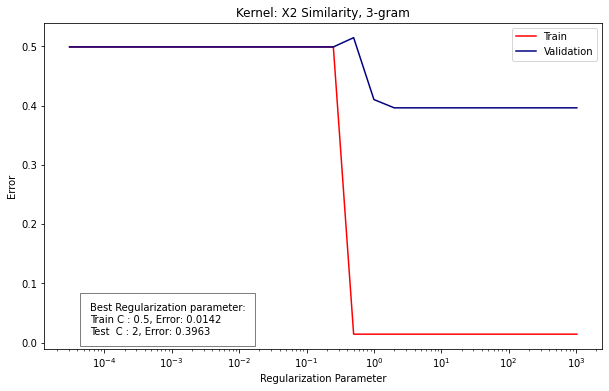

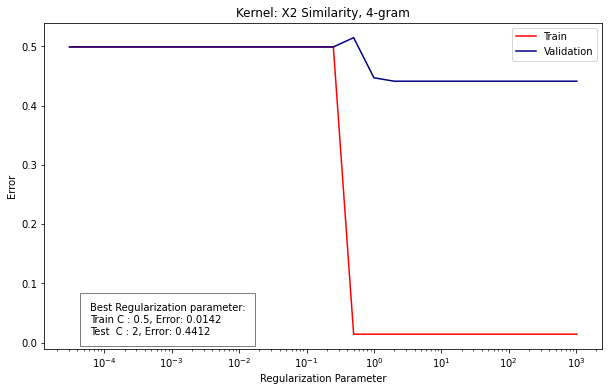

In [30]:
reg_parameters('X2 Similarity', Kchi_n, y_train)

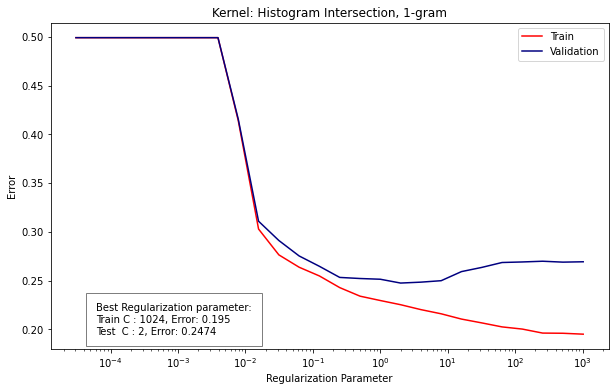

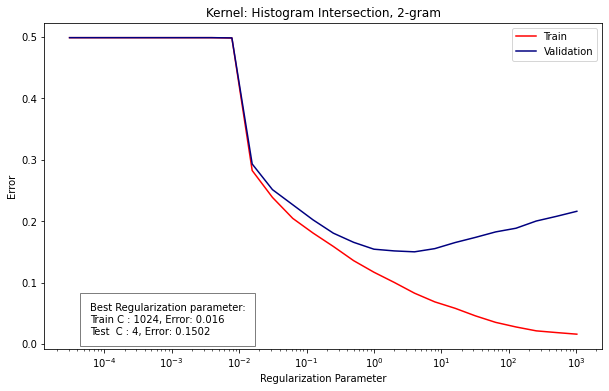

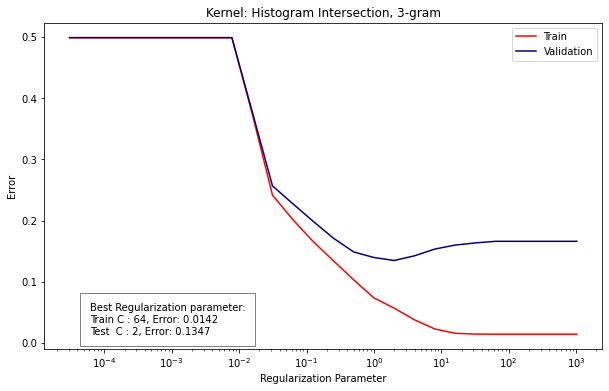

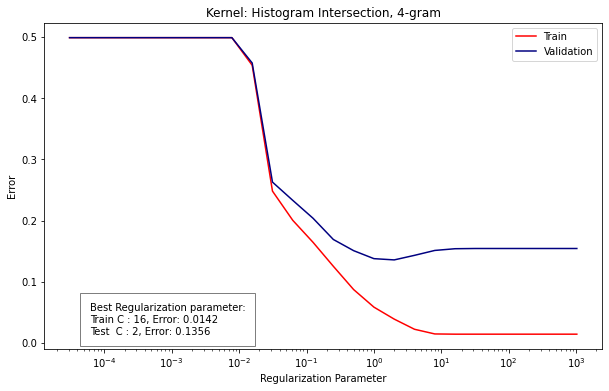

In [32]:
reg_parameters('Histogram Intersection', Khist_n, y_train)

## Problem 1(d)

Evaluate the performance of the SVMs in the test data set:
* Report the results in a table for the different evaluated configurations.
* Illustrate examples of errors (English words mistaken as Spanish, Spanish words
mistaken as English). Give a possible explanation for these mistakes.
* Discuss the results.

In [167]:
def eval_svm(kernel_func, k_name, n_grams_train,n_grams_test, C):
    reports = []
    
    for i in range(len(n_grams_train)):
        clf = svm.SVC(kernel = kernel_func, C = C[i])
        clf.fit(n_grams_train[i], y_train)
        accuracy = clf.score(n_grams_test[i],y_test)
        reports.append({
        "name":k_name,
        "n_gram": f"{i + 1}-gram",
        "C":C[i],
        "accuracy":accuracy
        
        })
    return reports
        

In [168]:
name = "Cosine Similarity"
C = [128,16,2,2]

table = []
for model in models:
    table = table + eval_svm(cosine_similarity, name, n_grams_train,n_grams_test, C)
results = pd.DataFrame.from_dict(table)
results

,name,n_gram,C,accuracy
0,Cosine Similarity,1-gram,128,0.736364
1,Cosine Similarity,2-gram,16,0.864015
2,Cosine Similarity,3-gram,2,0.879545
3,Cosine Similarity,4-gram,2,0.879545


In [169]:
name = "Histogram Intersection"
C = [2,4,2,2]

table = []
for model in models:
    table = table + eval_svm(compute_hist_kernel, name, n_grams_train,n_grams_test,C)
results = pd.DataFrame.from_dict(table)
results

,name,n_gram,C,accuracy
0,Histogram Intersection,1-gram,2,0.744697
1,Histogram Intersection,2-gram,4,0.854545
2,Histogram Intersection,3-gram,2,0.872727
3,Histogram Intersection,4-gram,2,0.867803


In [62]:
reports = []
C = [0.5,2,2,2]
for i in range(len(n_grams_train)):
    _clf = svm.SVC(kernel=chi2_kernel, C=C[i])
    _clf.fit(n_grams_train[i].todense(), y_train)
    predicted = _clf.predict(n_grams_test[i].todense())
    nt = len(y_test)
    errors = np.sum(predicted != y_test)
    accuracy = 1-(errors/nt)
    reports.append({
        'name': 'X2',
        'n_gram': f'{i + 1}-gram',
        'C': C[i],
        'accuracy': accuracy
    })

pd.DataFrame.from_dict(reports)

/home/brayancalderon/anaconda3/envs/machine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/brayancalderon/anaconda3/envs/machine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/brayancalderon/anaconda3/envs/machine/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/re

,name,n_gram,C,accuracy
0,X2,1-gram,0.5,0.721212
1,X2,2-gram,2.0,0.704924
2,X2,3-gram,2.0,0.614015
3,X2,4-gram,2.0,0.591288


## Discusión:
Se pusieron a prueba distintas regularizaciones a los kernels propuestos obteniendo así distintos resultados <br>

- Para el kernel de Cosine-Similarity se obtuvo un accuracy de 0.87 con tri-gramas y cuatri-gramas
- Para el kernel de Histogram-Intersection se obtuvo un accuracy de 0.8727 con tri-gramas
- Para el kernel de Chi-squared se obtuvo un accuracy de 0.72 con uni-gramas 

La mejor combinación se obtuvo con el kernel de Cosine-Similarity para un n-gram de tri-grama y cuatri-grama con un accuracy de 0.8. <br>
Por tanto podemos concluir que el mejor clasificador se obtuvo con el kernel de cosine-similarity.


# SVM Interpretability
## Problem 2(a)
Use the same dataset from question 1 and calculate a bag of n-grams representation. <br>
Utilizaremos el rango (1,3) para crear la instancia vectorizer ya que fue la que dio mejores resultados

In [63]:

vectorizer = CountVectorizer(ngram_range = (1, 3), analyzer = 'char')
# Vectorice the data
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

X_train.shape, X_test.shape

((5360, 3252), (2640, 3252))

## Problem 2(b)

Train a SVM using the histogram intersection kernel on this dataset.

In [64]:
clf = svm.SVC(C = 2.0, kernel = compute_hist_kernel)
clf.fit(X_train, y_train)

SVC(C=2.0, kernel=<function compute_hist_kernel at 0x7f98ad096d30>)

In [65]:
pred = clf.predict(X_test)
nt = len(y_test)
errors = np.sum(pred!= y_test)
accuracy = 1-(errors/nt)
accuracy

0.8727272727272728

## Problem 2(c)
Identify the support vectors found by the SVM training algorithm. Show the samples
corresponding to the support vectors with the maximum absolute value of the $\alpha_i$ coefficients, for both positive and negative values. Do they make sense? Analyze and
discuss.

In [66]:
indices = clf.support_
x_train.iloc[indices]

2868      podian
912         deje
1496        tiro
3024    utilizar
3886    jennifer
          ...   
7581       diana
7831      polite
5578      madame
5334     example
5390      movies
Name: palabra, Length: 2434, dtype: object

Tenemos 2434 Vectores de soporte <br>
Ahora buscamos los alfas en la representación dual cuyos alfas sean máximos.

In [78]:
coeffs = clf.dual_coef_
print(coeffs[0,:5])
print(f"El máximo alfa es: {max(coeffs[0])}")
abs_max_coeffs = np.where(abs(coeffs[0]) == 2)
print(f" Cantidad total de vectores: {len(abs_max_coeffs[0])}")


[-1.06096909 -0.34048992 -0.25417264 -1.05862364 -2.        ]
El máximo alfa es: 2.0
 Cantidad total de vectores: 1412


Donde -2 en los coeficientes que son de clase negativa y 2 para los que corresponden a la clase positiva. <br> 
El alfa máximo encontrado es 2, y dado  C = 2.0 encontramos 1412 vectores con valores máximos de alfa.

In [99]:
print("Vectores de soporte donde el alfa es -2 o 2 \n",  x_train.iloc[indices[abs_max_coeffs[0][:10]]])

Vectores de soporte donde el alfa es -2 o 2 
 3886      jennifer
3639      sentirse
3315        escape
765       sientate
3951    septiembre
2533        servir
3751         aldea
1881       olvides
1612         humor
848        ninguno
Name: palabra, dtype: object


## Vectores de soporte positivo

In [110]:
pos_max_coeffs = np.where(coeffs[0] >= 2)
print(f" Cantidad total de vectores positivos: {len(pos_max_coeffs[0])}")

 Cantidad total de vectores positivos: 706


In [129]:
print("Vectores de soporte donde el alfa es +2 \n",  x_train.iloc[indices[pos_max_coeffs[0][:20]]])

Vectores de soporte donde el alfa es +2 
 7818       permit
4292      minutes
4923        james
6540        bruce
5689      foreign
4439        uncle
5379        usual
7255     headache
4162       friend
4398    sometimes
7649       gloria
5544      stomach
5074         bomb
7071       patrol
5807        emily
5170        local
6723         lion
7013         exam
7126     jennifer
5620        santa
Name: palabra, dtype: object


## Vectores de soporte negativo

In [130]:
neg_max_coeffs = np.where(coeffs[0] <= -2)
print(f" Cantidad total de vectores negativos: {len(neg_max_coeffs[0])}")

 Cantidad total de vectores negativos: 706


In [131]:
print("Vectores de soporte donde el alfa es -2 \n",  x_train.iloc[indices[neg_max_coeffs[0][:20]]])

Vectores de soporte donde el alfa es -2 
 3886      jennifer
3639      sentirse
3315        escape
765       sientate
3951    septiembre
2533        servir
3751         aldea
1881       olvides
1612         humor
848        ninguno
3773         nubes
2392         suave
2760         barry
1112        estais
776           temo
1963          olor
485       hospital
3101       cultura
3399       russell
3047        gordon
Name: palabra, dtype: object


Como los vectores están ubicados en el borde/limite de inglés/español podriamos esperar palabras que sean similares tanto en español e inglés. <br>
palabras como escape,humor,hospital pueden ser ubicadas tanto en inglés o español. <br>
Letras como w o ñ son letras que son muy caracteristicas del idioma en que se hable, es por esta razón que estás letras no aparecen el boundary integradas a las palabras analizadas

## Problem 2(d)
For different test samples, calculate the classification manually, i.e. compute the kernel
between the sample and the support vectors and check how they contribute, positively or
negatively, to the final classification. Show those support vectors that have the highest
value of the kernel. Analyze and discuss.

In [132]:
x_test[2000:2050]

3836       policial
6408      subtitles
4840          likes
527           jugar
6105          armed
6483      potential
3209        atreves
6066      americans
5561           kate
565      encontrado
7510       superman
2862          vegas
7538        feeding
2183       aburrido
6412         damned
2034    felicidades
640       situacion
2445           joey
2412          seres
4003           have
730          george
5789          walls
4947          smoke
1964        ciencia
5296          older
3479          temas
2166         huesos
6940     officially
7634        dessert
325          tierra
1820        alcohol
5021         london
5159         papers
290          noches
1747      propiedad
3176        pusiste
7029         angels
2750        parezca
2372        tratado
4477         street
7752           plot
3102     revolucion
5292       cheering
3464          rueda
4372           high
7500    transferred
6714          plain
6663         insist
5091          raise
864           peter


### Muestra 1:["walls"]
Se calcula el kernel entre los vectores de soporte y la palabra

In [149]:
# Selecciona los vectores de soporte y la muestra
indices = clf.support_
X_sup_vector = X_train[indices]
X_sample = vectorizer.transform(['walls'])

# Calcula el kernel
K = compute_hist_kernel(X_sup_vector,X_sample).T

#Selecciona los coeficientes en la representación dual y el intercepto
coeffs = clf.dual_coef_
b_coeff = clf.intercept_[0]


X_sup_vector.shape, K.shape, coeffs.shape

((2434, 3252), (1, 2434), (1, 2434))

Se calcula por multiplicación punto a punto el kernel entre los vectores de soporte y la muestra, y la función discriminante

In [136]:
discriminant_func = K*coeffs
discriminant_value = discriminant_func.sum() + b_coeff
print(discriminant_value)

2.5385356690572713


In [143]:
min_discriminant_func = discriminant_func[0]
maxvecs = (-min_discriminant_func).argsort()[:10]
print(f"La contribución negativa más alta fue \n {x_train.iloc[maxvecs]}")

La contribución negativa más alta fue 
 6393        sally
2218    decirselo
5694        crash
1904        larry
4409        needs
5148        devil
4901        henry
4257       doctor
1237       mismos
3063       cierre
Name: palabra, dtype: object


In [148]:
max_discriminant_func = discriminant_func[0]
minvecs = (max_discriminant_func).argsort()[:10]
print(f"La contribución positiva más alta fue \n {x_train.iloc[minvecs]}")

La contribución positiva más alta fue 
 2552      orgullo
4938        turns
220       durante
5351    challenge
6043        media
3555       serias
4828      machine
5807        emily
6271       border
3589         that
Name: palabra, dtype: object


### Muestra ["propiedad"]

In [ ]:
# Selecciona los vectores de soporte y la muestra
indices = clf.support_
X_sup_vector = X_train[indices]
X_sample = vectorizer.transform(['propiedad'])

# Calcula el kernel
K = compute_hist_kernel(X_sup_vector,X_sample).T

#Selecciona los coeficientes en la representación dual y el intercepto
coeffs = clf.dual_coef_
b_coeff = clf.intercept_[0]


X_sup_vector.shape, K.shape, coeffs.shape

In [151]:
discriminant_func = K*coeffs
discriminant_value = discriminant_func.sum() + b_coeff
print(discriminant_value)

-1.1447341311576584


In [152]:
min_discriminant_func = discriminant_func[0]
maxvecs = (-min_discriminant_func).argsort()[:10]
print(f"La contribución negativa más alta fue \n {x_train.iloc[maxvecs]}")

La contribución negativa más alta fue 
 1455     huellas
2267      abrigo
7436        corn
342        podia
998       formas
5671     obvious
2201      empece
1303     cansado
4713    accident
7727      pierre
Name: palabra, dtype: object


In [153]:
max_discriminant_func = discriminant_func[0]
minvecs = (max_discriminant_func).argsort()[:10]
print(f"La contribución positiva más alta fue \n {x_train.iloc[minvecs]}")

La contribución positiva más alta fue 
 7714           barn
109          espera
1642        abierta
2387       permitir
6223       reporter
3409    aniversario
5418          cream
4141          three
528          cambio
3484          borde
Name: palabra, dtype: object


### Muestra ["alcohol"]

In [162]:
# Selecciona los vectores de soporte y la muestra
indices = clf.support_
X_sup_vector = X_train[indices]
X_sample = vectorizer.transform(['alcohol'])

# Calcula el kernel
K = compute_hist_kernel(X_sup_vector,X_sample).T

#Selecciona los coeficientes en la representación dual y el intercepto
coeffs = clf.dual_coef_
b_coeff = clf.intercept_[0]


X_sup_vector.shape, K.shape, coeffs.shape

((2434, 3252), (1, 2434), (1, 2434))

In [163]:
discriminant_func = K*coeffs
discriminant_value = discriminant_func.sum() + b_coeff
print(discriminant_value)

0.8159813701981913


In [164]:
min_discriminant_func = discriminant_func[0]
maxvecs = (-min_discriminant_func).argsort()[:10]
print(f"La contribución negativa más alta fue \n {x_train.iloc[maxvecs]}")

La contribución negativa más alta fue 
 6766           mile
3588           poli
7836         aliens
7303          alpha
5385      destroyed
5371         prefer
1105          abrir
2400          jenny
6608        arrange
3652    cigarrillos
Name: palabra, dtype: object


In [165]:
max_discriminant_func = discriminant_func[0]
minvecs = (max_discriminant_func).argsort()[:10]
print(f"La contribución positiva más alta fue \n {x_train.iloc[minvecs]}")

La contribución positiva más alta fue 
 3801       oscura
6724     exercise
5246     possibly
1530      autobus
777         broma
5865      touched
5998      smoking
7703    structure
1675        pollo
3315       escape
Name: palabra, dtype: object


Se puede observar que para palabras en inglés como "walls" la contribución positiva es mayor que la negativa por lo que el clasificador lo ubica 
como palabra inglesa, de igual forma para la palabra "propiedad" se tiene una contribución negativa mayor y se ubica en como palabra española, finalmente la palabra "alcohol" tiene una contribución positiva mayor pero de menor contribución que walls, sin embargo esta palabra podría estar ubicada tanto en español como en inglés.

## Problem 3
We will implement a kernel version of logistic regression. The goal is to train a logistic
regression model on a feature space F. Specifically, the discriminant function of the model is
given by:

$$f(x) = P(C = 1|x) = \sigma(w\Phi(x))$$


where $\Phi : X \rightarrow F$ is a mapping function associated with a kernel function $k : X \times X \rightarrow R$
and $\sigma$ is the logistic function.

Assume that the weight vector w is expressed as a linear combination of the training samples:

$$w = \sum_{i=1}^l\alpha_i\Phi(x_i)$$

### Problem 3(a) Discriminant function expression
Write a expression of the discriminant function expressed in terms of the kernel and the
coeficients $\alpha_i$.

La función discriminante puede ser escrita como: <br>
donde $\ell$ es el número de muestras de entrenamiento
$$f(x) = \sigma(w \cdot \Phi(x))=\sigma\big(\big[\sum_{i=1}^\ell\alpha_i\Phi(x_i)\big]\cdot\Phi(x)\big)$$
$$f(x) = \sigma\big(\sum_{i=1}^\ell\alpha_i[\Phi(x_i)\cdot\Phi(x)]\big)$$
por tanto, 
$$ f(x) = \sigma\big(\sum_{i=1}^\ell\alpha_i k(x_i,x)\big)$$


### Problem 3(b) Formulation of the learning problem

Formulate the problem of learning the parameters of the model as an optimization problem that looks for the parameters $\alpha_i$ that minimize a cross entropy loss function.